# Indonesian POS Tagging using CRF

Install the needed library

In [2]:
!pip install sklearn_crfsuite

     |████████████████████████████████| 747kB 4.3MB/s 


Import used library

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from collections import Counter
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

Read the dataset. The dataset is from https://github.com/famrashel/idn-tagged-corpus but converted into CSV for easier processing

In [4]:
data = pd.read_csv('data/postag.csv', keep_default_na=False)
data.head()

,sentence_num,token,tag
0,0,Kera,NN
1,0,untuk,SC
2,0,amankan,VB
3,0,pesta olahraga,NN
4,1,Pemerintah,NNP


Show the POS tag distribution in the dataset

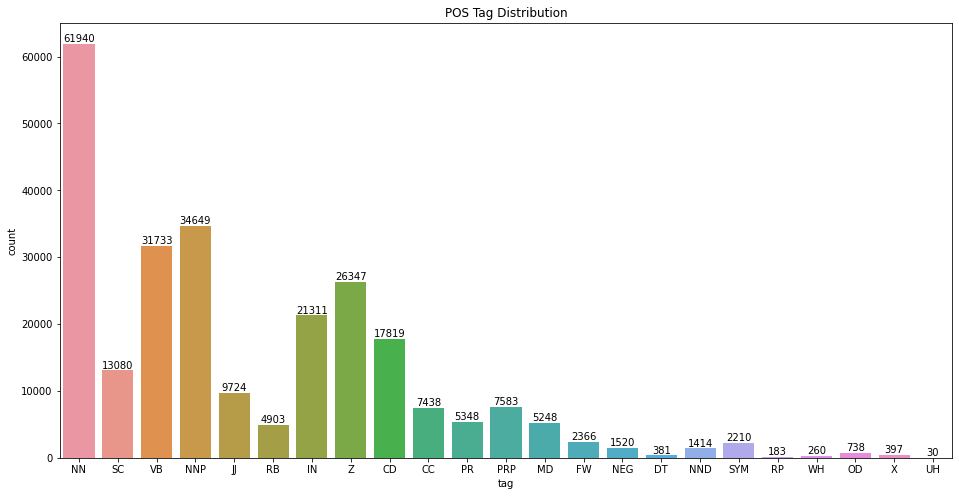

In [5]:
plt.figure(figsize=(16, 8))
plt.title('POS Tag Distribution')
ax = sns.countplot(x='tag', data=data)

for p in ax.patches:
  x=p.get_bbox().get_points()[:,0]
  y=p.get_bbox().get_points()[1,1]
  ax.annotate('{:d}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

plt.show()

Split the dataset into train and test dataset, then train the CRF model

In [8]:
def dataset_to_seq(dataset):
  return [(tok, tag) for tok, tag in zip(
      dataset['token'].values.tolist(),
      dataset['tag'].values.tolist())]

def word2features(sent):
    feature_list = []
    for i in range(len(sent)):
      token = sent[i]
      features = {
          'token': token,
          'token.lower()': token.lower(),
          'token.istitle()': token.istitle(),
          'token.isupper()': token.isupper(),
          'token[:2]': token[:2],
          'token[:3]': token[:3],
          'token[-3:]': token[:-3],
          'token[-2:]': token[:-2],
      }
      if i > 0:
          token1 = sent[i-1]
          features.update({
              '-1:token.lower()': token1.lower(),
              '-1:token.istitle()': token1.istitle(),
              '-1:token.isupper()': token1.isupper(),
          })
      else:
          features['BOS'] = True
      if i < len(sent)-1:
          token1 = sent[i+1]
          features.update({
              '+1:token.lower()': token1.lower(),
              '+1:token.istitle()': token1.istitle(),
              '+1:token.isupper()': token1.isupper(),
          })
      else:
          features['EOS'] = True
      
      feature_list.append(features)

    return feature_list

def sent2features(sent):
    return word2features([token_tag[0] for token_tag in sent])

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

def dataset_to_features_labels_seq(dataset):
  sentences = list(dataset.groupby('sentence_num').apply(dataset_to_seq))
  X = [sent2features(s) for s in sentences]
  y = [sent2labels(s) for s in sentences]
  return X, y

X, y = dataset_to_features_labels_seq(data)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)
y_pred = crf.predict(X_valid)
print(metrics.flat_classification_report(y_valid, y_pred, digits=4))

              precision    recall  f1-score   support

          CC     0.9875    0.9814    0.9845      1452
          CD     0.9928    0.9907    0.9918      3774
          DT     1.0000    0.9595    0.9793        74
          FW     0.9398    0.7297    0.8215       492
          IN     0.9606    0.9696    0.9651      4375
          JJ     0.9558    0.9397    0.9477      1889
          MD     0.9920    0.9910    0.9915      1001
         NEG     0.9937    0.9937    0.9937       317
          NN     0.9615    0.9761    0.9688     12314
         NND     0.9425    0.9535    0.9480       258
         NNP     0.9567    0.9625    0.9596      7066
          OD     0.9062    0.9539    0.9295       152
          PR     0.9981    0.9942    0.9962      1042
         PRP     0.9980    0.9980    0.9980      1493
          RB     0.9844    0.9556    0.9698       924
          RP     1.0000    1.0000    1.0000        36
          SC     0.9507    0.9471    0.9489      2626
         SYM     0.9940    

Show what the CRF model have learnt while training

In [9]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))
        
print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))
print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
6.371633 VB       token[:2]:di
6.314019 NNP      token.istitle()
5.847463 CD       +1:token.lower():persen
5.792135 NNP      token.isupper()
5.587934 VB       token[:3]:ber
5.425713 IN       token.lower():di
5.367213 IN       token.lower():per
5.135805 IN       token.lower():menurut
5.066365 CD       token[:2]:1R
4.995911 PRP      token.lower():mereka
4.906084 OD       token.lower():pertama
4.861747 IN       token.lower():kepada
4.818932 IN       token.lower():pada
4.811077 DT       token.lower():para
4.782232 CD       +1:token.lower():juta
4.737103 PRP      token.lower():kami
4.662852 SC       token.lower():ketika
4.604368 CC       token.lower():atau
4.585944 CD       token[:2]:11
4.573518 SC       token.lower():sebelum
4.555896 CD       token.lower():banyak
4.538835 SC       token.lower():bahwa
4.496899 CD       token[:2]:19
4.472201 VB       token[:2]:me
4.469703 VB       token[:3]:men
4.432517 IN       token.lower():tanpa
4.423645 PRP      token.lower():dia
4.391726 M

Save the model into file `model_postag`

In [10]:
with open('model_postag', 'wb') as model_out:
  pickle.dump(crf, model_out)

## Try The Model

Create the `POSTagger` class, which we will use for POS tagging

In [11]:
import nltk
from nltk.tokenize import word_tokenize
import pickle
nltk.download('punkt')

class POSTagger():
  def __init__(self):
    with open('model_postag', 'rb') as model:
      self.model = pickle.load(model)

  def tag(self, sent):
    if isinstance(sent, list):
      self.sent_tokenized = sent
    elif isinstance(sent, str):
      self.sent_tokenized = word_tokenize(sent)
    self.pos_tags = self.model.predict_single(self.word2features(self.sent_tokenized))
    return self.pos_tags

  def word2features(self, sent):
    feature_list = []
    for i in range(len(sent)):
      token = sent[i]
      features = {
          'token': token,
          'token.lower()': token.lower(),
          'token.istitle()': token.istitle(),
          'token.isupper()': token.isupper(),
          'token[:2]': token[:2],
          'token[:3]': token[:3],
          'token[-3:]': token[:-3],
          'token[-2:]': token[:-2],
      }
      if i > 0:
          token1 = sent[i-1]
          features.update({
              '-1:token.lower()': token1.lower(),
              '-1:token.istitle()': token1.istitle(),
              '-1:token.isupper()': token1.isupper(),
          })
      else:
          features['BOS'] = True
      if i < len(sent)-1:
          token1 = sent[i+1]
          features.update({
              '+1:token.lower()': token1.lower(),
              '+1:token.istitle()': token1.istitle(),
              '+1:token.isupper()': token1.isupper(),
          })
      else:
          features['EOS'] = True
      
      feature_list.append(features)

    return feature_list

pos_tagger = POSTagger()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Try the model

In [12]:
print(pos_tagger.tag("Meraih peringkat kedua."))
print(pos_tagger.tag(["Meraih", "peringkat", "kedua", "."]))

['VB', 'NN', 'OD', 'Z']
['VB', 'NN', 'OD', 'Z']


References:
- https://towardsdatascience.com/named-entity-recognition-and-classification-with-scikit-learn-f05372f07ba2